In [ ]:
import pandas as pd
import json
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
from IPython.display import HTML
from IPython import display
import importlib
import os
import matplotlib.pyplot as plt
from PIL import Image
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
# import edward_tools.create_cfqr as create_cfqr
U0_kBT_ratio = U0_1/k_BT
rc_dict = {'font.size':16, 'axes.labelsize':'large', 'ytick.right':False,'legend.loc':'upper right', 'legend.fontsize':'xx-small', 'figure.autolayout':True, 'figure.figsize': (10,10), 'mathtext.fontset':'stix', 'font.family':'STIXGeneral'}


mpl.rcParams.update(rc_dict)


In [ ]:
# df['simulation_id'] = [x['simulation_id'] for x in df['simulation_data'].values]

In [ ]:
# df.to_json("coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/gallery.json")

In [ ]:
def getSimulationID(df):
    return [item["simulation_id"] for item in df["simulation_data"]] 

def getDataByComment(df, identifier):
    target = df[df["comment"].str.find(identifier) == 0]
    return target

def getDataByField(df, field):
    return list(target[field])


def showGraph(sim_id):
    work_distribution_img = Image.open(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.png")
    work_distribution_data = np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")
    work_statistic_img = Image.open(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_statistic.png")
    work_statistic_data = np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_statistic.npy")
    display(work_distribution_img)
    display(work_statistic_img)
    # work_distribution_img.show()
    print(sim_id)
    return work_distribution_data, work_statistic_data

def getSimulationWorkStatistics(df, sim_id, folderPath = "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"):
    """
    'params', 'initial_parameter_dict', 'protocol_list_item',
       'simulation_data', 'circuit_parameters', 'sim_params', 'jarzynski_term',
       'mean_work', 'fidelity', 'keyStep_work_statistic',
       'fidleity_time_array', 'target_step_index_info', 'comment', 'script',
       'simulation_id'
    """
    
    target = getDataByID(df, sim_id)
    dt = list(target['params'])[0]["dt"]
    N =  list(target['params'])[0]["N"]
    
    work_distribution_data = np.load(f"{folderPath}/{sim_id}_work_distribution.npy")
    work_statistic_data = np.load(f"{folderPath}/{sim_id}_work_statistic.npy")
    fidelity_time_array = np.load(f"{folderPath}/{sim_id}_fidelity_time_array.npy")
    jarzyn_term = np.mean(np.exp(-work_distribution_data))
    jarzyn_term_error = 3 * np.std(np.exp(-work_distribution_data)) / np.sqrt(N)
    keyStep_work_statistic = target['keyStep_work_statistic'].values[0]
    
    target_step_index_info = list(target['target_step_index_info'])[0]
    target_step_index = list(range(target_step_index_info['start'], target_step_index_info['end']+1, target_step_index_info['step']))

    return {
        "work_distribution_data": work_distribution_data,
        "work_statistic_data": work_statistic_data,
        "fidelity_time_array": fidelity_time_array,
        "target_time_index": target_step_index,
        "keyStep_work_statistic": keyStep_work_statistic, 
        "N": N, "dt": dt, "mean_W": np.mean(work_distribution_data), "mean_W_error": np.std(work_distribution_data) / np.sqrt(len(work_distribution_data)),
        "jarzyn_term": jarzyn_term, "jarzyn_term_error": jarzyn_term_error
    }

def loadDataFrame(folderPath = "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"):
    df = pd.read_json(f"{folderPath}/gallery.json")
    df['simulation_id'] = [x['simulation_id'] for x in df['simulation_data'].values]
    df['comment'] = [item['comment'] for item in df["params"]]
    return df


def getDataByID(df, sim_id):
    target = df[df["simulation_id"] == sim_id]
    return target


def getFidelityTimeGraph(fidelity_time_array, target_step_index):
    """
    trace the fidelity of the systems  at different time as 4 different plots
    """
    metastable_state_array = ["00", "01", "10", "11"]
    fidelity_time_array = np.array(fidelity_time_array, dtype = float)
    
    fig, ax = plt.subplots(2, 2, figsize = [10, 9])
    ax_flatten = ax.flatten()

    for i, _ax in enumerate(ax_flatten):
        _ax.plot(target_step_index, fidelity_time_array[:, 0, i], label = "00")
        _ax.plot(target_step_index, fidelity_time_array[:, 1, i], label = "01")
        _ax.plot(target_step_index, fidelity_time_array[:, 2, i], label = "10")
        _ax.plot(target_step_index, fidelity_time_array[:, 3, i], label = "11")
        _ax.set_title(f"time evolution of fidelity inside {metastable_state_array[i]}")
        _ax.legend()
    plt.show()

def showFidelity(target):

    final_percentage_matrix = np.array([d["final_percentage"] for d in list(target["fidelity"])[0]]).T
    text_box_array = ["\n".join(row) for row in final_percentage_matrix]
    params_list = list(target["params"])[0]
    fig, ax = plt.subplots(1, 2, figsize = [10, 4])
    # plt.figure(figsize=[4, 4])
    # plt.title(f"N = {params_list['N']}, dt = {params_list['dt']}")
    _ax = ax[1]
    _ax.set_xlim(-5, 5);plt.ylim(-5, 5);
    _ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
    _ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
    _ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

# ideal_fidelity = np.array([['0.500', '0.000', '0.500', '0.000'], ['0.500', '0.000', '0.500', '0.000'],
#                           ['0.000', '0.500', '0.000', '0.500'], ['0.000', '0.500', '0.000', '0.500']]).T
# text_box_array = ["\n".join(row) for row in ideal_fidelity]
# plt.figure(figsize=[4, 4])
# plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
# _ax = ax[0]
# _ax.set_xlim(-5, 5);plt.ylim(-5, 5);
# _ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
# _ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
# _ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

In [ ]:
rc_dict = {'font.size':16, 'axes.labelsize':'large', 'ytick.right':False,'legend.loc':'upper right', 'legend.fontsize':'xx-small', 'figure.autolayout':True, 'figure.figsize': (10,10), 'mathtext.fontset':'stix', 'font.family':'STIXGeneral'}

In [ ]:
import matplotlib as mpl

In [ ]:
rc_dict = {'font.size':16, 'axes.labelsize':'large', 'ytick.right':False,'legend.loc':'upper right', 'legend.fontsize':'xx-small', 'figure.autolayout':True, 'figure.figsize': (10,10), 'mathtext.fontset':'stix', 'font.family':'STIXGeneral'}

In [ ]:
plt.rc_context(rc_dict)


# show a result

In [ ]:
df = loadDataFrame()
target = getDataByComment(df,  "Experiment 4a (2024/10/14)")
# target = getDataByID(df, "e93085b7e966e001bddcb9c6e7a09f240fa8f9f679175d8dffbdc682d6ab43fb")
[50, 100, 500, 1000]
sim_id = getSimulationID(target)[-1]

result_info = getSimulationWorkStatistics(df, sim_id)
print(sim_id)
# print(result_info)

In [ ]:
target

In [ ]:
params = list(target['params'])[-1]
circuit_parameter = list(target['circuit_parameters'])
protocol_list = list(target['protocol_list_item'])[0]
initial_parameter_dict = list(target['initial_parameter_dict'])[0]
protocol_time_array = [item["duration"] for item in protocol_list]

protocol_time_array.insert(0, 0)
print(protocol_time_array)
protocol_time_array = np.cumsum(protocol_time_array)
print(protocol_time_array)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[7, 3])

ax[0].hist(result_info['work_distribution_data'], bins = 100)
ax[1].plot(np.array(range(len(result_info['work_statistic_data'])))[::100] * 0.1, result_info['work_statistic_data'][::100, 0])
print("-" * 30 + " Information " + "-" * 30 )

work_distribution = result_info['work_distribution_data']
N = len(work_distribution)
work_mean = result_info['work_statistic_data'][:, 0]
mean_work_std = np.std(work_distribution)

jarzyn_term = np.mean(np.exp(-work_distribution))
jarzyn_term_std = np.std(np.exp(-work_distribution))
circuit_parameter = target['circuit_parameters'].values[0]
initial_parameter = target['initial_parameter_dict'].values[0]
protocol_list_item = target['protocol_list_item'].values[0]

target_time_index = target['params'].values[0]['protocol_time_array']
work_done_array = target['keyStep_work_statistic'].values[0]
work_done_of_each_step = np.array(work_done_array)[1:] - np.array(work_done_array)[:-1]
# W_M = work_done_array[4][0] - work_done_array[0][0]
# W_M_err = np.sqrt(work_done_array[4][1]**2 + work_done_array[0][1]**2) 
# W_C = work_done_array[-1][0] - work_done_array[4][0]
# W_C_err = np.sqrt(work_done_array[8][1]**2 + work_done_array[4][1]**2)


Measure_Erasue_steps = [0, 1, 2, 3]
Control_Steps = [4, 5, 6, 7]


print(target["comment"].values[0])
print("(a) parameters")
print(sim_id)
print()
# print(f"N = {params['N']}, dt = {params['dt']}")
print(f"phi_1dcx_on: {circuit_parameter['phi_1_dcx_on']}, phi_2dcx_on: {circuit_parameter['phi_2_dcx_on']}, M_12_on: {circuit_parameter['M_12_on']:.3g}")
print(f"L_factor = {circuit_parameter['L_factor']:.3g}, C_factor = {circuit_parameter['C_factor']}, I_m_factor = {circuit_parameter['I_m_factor']}, gamma = {initial_parameter_dict['gamma_1']}")
print([x["duration"] for x in protocol_list])
print()
print("(b) thermodynamic cost")
print(f"mean: {np.mean(result_info['work_distribution_data']):.3g} ± {mean_work_std * 3 / np.sqrt(N):.3g}")
print(f"jarzyn: {jarzyn_term:.3g} ± {3 * jarzyn_term_std / np.sqrt(N):.3g}")
print()

print("(c) work analysis")
print(f"work_done = {work_done_of_each_step}" )
# print(f"measurement + reset = {W_M:.3g} ± {W_M_err * 3 / np.sqrt(N):.3}, deviation = {W_M - 0.693:.3g}")
# print(f"control = {W_C:.3g} ± {W_C_err * 3 / np.sqrt(N):.3g}, deviation = {0.693 + W_C:.3g}")


# print("measurement + reset = ", np.sum([work_done_of_each_step[i, 0] for i in Measure_Erasue_steps]))
# print("control = ", np.sum([work_done_of_each_step[i, 0] for i in Control_Steps]))
# print(np.sum(work_done_of_each_step[:, 0]))


In [ ]:
print(list(target['circuit_parameters'])[-1])

In [ ]:
print(list(target['protocol_list_item'])[-1])

In [ ]:
fidelity_time_array = result_info['fidelity_time_array'].astype("float")

fig, ax = plt.subplots(2, 2, figsize=[7, 7])

pColor = {"00": "#061DF7", "01": "#FCEF51", "10": "#3FC7F2", "11": "#F7B6D2"}

# 00
ax[1][0].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,0], color = pColor.values())
ax[1][0].set_ylim(0, 1)
ax[1][0].axhline(0.5, linestyle='--')

# 01
ax[0][0].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,1], color = pColor.values())
ax[0][0].set_ylim(0, 1)
ax[0][0].axhline(0.5, linestyle='--')

# 10
ax[1][1].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,2], color = pColor.values())
ax[1][1].set_ylim(0, 1)
ax[1][1].axhline(0.5, linestyle='--')

# 11
ax[0][1].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,3], color = pColor.values())
ax[0][1].set_ylim(0, 1)
ax[0][1].axhline(0.5, linestyle='--')

In [ ]:
fidelity_time_array[-1]

In [ ]:
work_done_array

In [ ]:
initial_parameter_dict = pd.DataFrame.from_records([target['initial_parameter_dict'].values[0]])
# circuit_parameter = pd.DataFrame.from_records([target['params'].values[0]['circuit_parameters']])


In [ ]:
initial_parameter_dict

In [ ]:
circuit_parameter

In [ ]:
showGraph(list(target["simulation_data"])[0]['simulation_id'])

In [ ]:
plt.hist(result_info['work_distribution_data'], 100)
plt.show()

In [ ]:
np.mean(np.exp(-result_info['work_distribution_data']))

In [ ]:
def substep_work_extraction(target, offset = False):
    sim_id = getSimulationID(target)[0]
    result_info = getSimulationWorkStatistics(df, sim_id)
    
    _dt = result_info['dt']
    
    work_statistic_data = result_info['work_statistic_data']
    protocol_list_item = list(target["protocol_list_item"])[0]
    print(protocol_list_item)
    protocol_time_array = [item["duration"] for item in protocol_list_item]
    protocol_time_array = np.cumsum(protocol_time_array)/_dt
    work_done_at_all_stages = [work_statistic_data[int(i)-1][0] for i in protocol_time_array]
    work_done_at_all_stages.insert(0, 0)
    work_done_at_all_stages = np.array(work_done_at_all_stages)
    net_work_done = work_done_at_all_stages[1:] - work_done_at_all_stages[:-1]
    offset_U = 0
    
    if offset:
        offset_U = min_U_at_each_non_linear_pot[1:] - min_U_at_each_non_linear_pot[:-1]
    return net_work_done - offset_U
    
    

In [ ]:
work_done_each_step = substep_work_extraction(target, offset = True)

In [ ]:
np.sum(work_done_each_step[3:])

In [ ]:
np.sum(work_done_each_step)

In [ ]:
work_done_each_step

In [ ]:
folderPath="coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery_backup_2"

data = {
    "sym_no_4_well": {
        "sim_id": "025f7a325acf562383d7181a0906450e01a9576d1494655024a0969ba6bde877",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"
    },
    "sym_with_4_well":  {
        "sim_id": "5835c465dfb0c50caaef6205c561fb3dea34e7960ab781a7fd070f22f9ea9671",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"
    },
    
    
    "uncompensated_asym_with_4_well": {
        "sim_id": "9816cf557ffeb4826ad33b3dd13fe11027d349ff45957aafac3644795fd6d774",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery_backup_2"
    },
    
    "uncompensated_highly_asym_with_4_well": {
        "sim_id": "fab034580c0c7e2a00ecf5429ea6ff72d907810165c97f924a00bdb1790f385d",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"
    },
    "uncompensated_highly_asym_with_4_well": {
        "percentage": "5%",
        "sim_id": "56e42d9dabf1459c681a3389a1bfb48084fcf241c6da7751781be221b1664c1a",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"
    },
    "uncompensated_asym_without_4_well": {
        "sim_id": "eb0aed01b2eda52e06b2cc57b3153e48e95e0c0fb97665693940b0cbf8a07650",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery_backup_2"
    },

    "compensated_asym_without_4_well": {
        "sim_id": "a9b8be02381e39bf083f2fcc14c1255e328b7446312d82725ecd84b257993ab7",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery"
    },
    "compensated_asym_with_4_well": {
        "sim_id": "59126f408f8986ab3e9ee64405661b0ba5abf44143b9634af72c8df14f008d78",
        "folder": "coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery_backup_2"
    },
}


choosen_data = data["sym_no_4_well"]
sim_id = choosen_data['sim_id']
folderPath = choosen_data['folder']


df = loadDataFrame(folderPath=folderPath)
sim_id = "5df55d19d6e82cadbbd7d8842d18e6f1985e65de5054114e5574edd0b2a749f3"
# target = getDataByComment(df, "Experiment 3 (2024/3/13)")
target = getDataByID(df, sim_id)
# target = df
# sim_id = getSimulationID(target.tail(1))[0]
result_info = getSimulationWorkStatistics(df, sim_id, folderPath = folderPath)


In [ ]:
metastable_state_array = ["00", "01", "10", "11"]
fig, ax = plt.subplots(2, 3, figsize = [12, 6])
ax_flatten = ax.flatten()
# work_distribution_graph
work_distribution_data = result_info['work_distribution_data']
work_mean = np.mean(work_distribution_data)
ax_flatten[0].hist(work_distribution_data, bins = 50)
ax_flatten[0].set_xlabel(r"work ($k_BT$)", fontsize = 12)
ax_flatten[0].set_ylabel(r"counts", fontsize = 12)
ax_flatten[0].vlines(x= work_mean, ymin= 0, ymax=3700, colors="r", linestyles="--")
ax_flatten[0].text(work_mean + 0.2, 3200, f"<W> = {work_mean:.3g}", c="r", fontsize = 12)
print(work_mean)

# work_statistic_graph
target_time_index = result_info['target_time_index']
target_time = np.array(result_info['target_time_index']) * 1/5000
key_time = target['params'].values[0]['protocol_time_array']
work_statistic_data = result_info['work_statistic_data']
work_mean_time_series = work_statistic_data[:, 0]
work_mean_error_time_series = work_statistic_data[:, 1]
ax_flatten[3].set_xlabel(r"time", fontsize = 12)
ax_flatten[3].set_ylabel(r"work ($k_BT$)", fontsize = 12)
ax_flatten[3].plot(target_time, work_mean_time_series)
for i, x in enumerate(key_time):
    ax_flatten[3].vlines(x, ymin = -2.6, ymax = 1.5, linestyle = '--', color = 'r')
    t_text = f"$t_{i}$"
    ax_flatten[3].text(x-10, 1.8, t_text)

fidelity_time_array = result_info['fidelity_time_array'].astype("float")
fidelity_ax = [ax_flatten[1], ax_flatten[2], ax_flatten[4], ax_flatten[5]]
for i, _ax in enumerate(fidelity_ax):
    _ax.plot(target_time, fidelity_time_array[:, 0, i], label = "00")
    _ax.plot(target_time, fidelity_time_array[:, 1, i], label = "01")
    _ax.plot(target_time, fidelity_time_array[:, 2, i], label = "10")
    _ax.plot(target_time, fidelity_time_array[:, 3, i], label = "11")
    _ax.set_xlabel("time")
    _ax.set_ylabel("proportion")
    _ax.set_title(f"time evolution of fidelity inside {metastable_state_array[i]}")
    if i == 0:
        _ax.legend()

    for i, x in enumerate(key_time):
        _ax.vlines(x, ymin = 0, ymax = 1.1, linestyle = '--', color = 'grey', alpha = 0.5)
        t_text = f"$t_{i}$"
        # _ax.text(x-10, 1.8, t_text)
    
plt.tight_layout()



In [ ]:
fidelity_time_array[-1, :, :]

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[7, 7])

pColor = {"00": "#061DF7", "01": "#FCEF51", "10": "#3FC7F2", "11": "#F7B6D2"}

# 00
ax[1][0].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,0], color = pColor.values())
ax[1][0].set_ylim(0, 1)
ax[1][0].axhline(0.5, linestyle='--')

# 01
ax[0][0].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,1], color = pColor.values())
ax[0][0].set_ylim(0, 1)
ax[0][0].axhline(0.5, linestyle='--')

# 10
ax[1][1].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,2], color = pColor.values())
ax[1][1].set_ylim(0, 1)
ax[1][1].axhline(0.5, linestyle='--')

# 11
ax[0][1].bar(["00", "01", "10", "11"], fidelity_time_array[-1,:,3], color = pColor.values())
ax[0][1].set_ylim(0, 1)
ax[0][1].axhline(0.5, linestyle='--')

In [ ]:
params = list(target['params'])[0]
circuit_parameter = list(target['circuit_parameters'])[0]
protocol_list = list(target['protocol_list_item'])[0]
initial_parameter_dict = list(target['initial_parameter_dict'])[0]
protocol_time_array = [item["duration"] for item in protocol_list]

In [ ]:
print("-" * 30 + " Information " + "-" * 30 )
work_done_array = target['keyStep_work_statistic'].values[0]
work_done_of_each_step = np.array(work_done_array)[1:] - np.array(work_done_array)[:-1]

Measure_Erasue_steps = [0, 1, 2, 3]
Control_Steps = [4, 5, 6, 7]

# Measure_Erasue_steps = [0, 1, 2]
# Control_Steps = [3, 4, 5, 6]


print(target["comment"].values[0])
print("(a) parameters")
print(sim_id)
print()
# print(f"N = {params['N']}, dt = {params['dt']}")
print(f"phi_1dcx_on: {circuit_parameter['phi_1_dcx_on']}, phi_2dcx_on: {circuit_parameter['phi_2_dcx_on']}, M_12_on: {circuit_parameter['M_12_on']:.3g}")
print(f"L_factor = {circuit_parameter['L_factor']:.3g}, C_factor = {circuit_parameter['C_factor']}, I_m_factor = {circuit_parameter['I_m_factor']}, gamma = {initial_parameter_dict['gamma_1']}")
print([x["duration"] for x in protocol_list])
print()
print("(b) thermodynamic cost")
print(f"mean work = {target['mean_work'].values[0]:.3g} ± {3 * result_info['mean_W_error']:.3g}")
print(f"jarzyn = {target['jarzynski_term'].values[0]:.3g} ± {3 * result_info['jarzyn_term_error']:.3g}")
print()

print("(c) work analysis")
# print(f"work_done = {work_done_of_each_step}" )
print("measurement + reset = ", np.sum([work_done_of_each_step[i, 0] for i in Measure_Erasue_steps]))
print("control = ", np.sum([work_done_of_each_step[i, 0] for i in Control_Steps]))
print(np.sum(work_done_of_each_step[:, 0]))

# compare results

In [ ]:
sim_id_to_compare = ["c2e2d9a10eca0b331ca768e3dad02ab1283557d1d2b7e3fdb56dbf92a868bba9", 
                     "91b01116c21a74c8c79a0abb766c316789892c7d3bfad8d88b78df2005fb2009",
                     "64df0cd6e5cbd1d310e9b893bc16f49b302188661080f648ba980b149dc6da03"]


In [ ]:
df = loadDataFrame()
result_array = []
circuit_parameter_array = []
initial_parameter_dict_array = []
for _sim_id in sim_id_to_compare:
    target = getDataByID(df, _sim_id)
    result_info = getSimulationWorkStatistics(df, _sim_id)
    result_array.append(result_info)
    initial_parameter_dict = target['initial_parameter_dict'].values[0]
    initial_parameter_dict_array.append(initial_parameter_dict)
    
    circuit_parameter = target['params'].values[0]['circuit_parameter']
    circuit_parameter_array.append(circuit_parameter)
    

In [ ]:
df_for_comparison = pd.DataFrame.from_records(result_array)
df_for_circuit_parameter_array = pd.DataFrame.from_records(circuit_parameter_array)
df_for_initial_parameter_dict_array= pd.DataFrame.from_records(initial_parameter_dict_array)

In [ ]:
df_for_comparison[["N", "dt", "mean_W", "jarzyn_term"]]

In [ ]:
df_for_circuit_parameter_array[['C_factor', 'L_factor', 'I_m_factor', 'phi_1_dcx_on', 'phi_2_dcx_on', 'M_12_on']]

In [ ]:
df_for_initial_parameter_dict_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = [10, 9])
ax_flatten = ax.flatten()
df_for_comparison['work_distribution_data'].values
ax_flatten[0].hist(df_for_comparison['work_distribution_data'].values[0], bins = 20)
ax_flatten[1].hist(df_for_comparison['work_distribution_data'].values[1], bins = 20)

# show a result of a group of simulation

In [ ]:
df = loadDataFrame()
# target = getDataByComment(df,  "Experiment 2 (2024/8/9)") 
# target = getDataByComment(df,  "Experiment 1 (2024/6/10)") # case 1
# target = getDataByComment(df,  "Experiment 2 (2024/6/19)") # case 2
# target = getDataByComment(df, "Experiment 1 (2024/7/8)") 
target = getDataByComment(df, "Experiment 5 (2024/7/3)") # case 3, 20


target = getDataByComment(df, "Experiment 6 (2024/10/14") # case 3, 20


# target = getDataByID(df, "025f7a325acf562383d7181a0906450e01a9576d1494655024a0969ba6bde877") # case 4
# index = 7
sim_id_array = list(target['simulation_id'].values)

# 
statistic_data_array = [getSimulationWorkStatistics(df, _sim_id) for _sim_id in sim_id_array]

In [ ]:
[x["mean_W"] for x in statistic_data_array]

In [ ]:
# work_dist_array = np.concatenate([_data['work_distribution_data'] for _data in statistic_data_array])
# work_dist_array  = np.repeat(work_dist_array, 20)
# work_stat_array = np.array([_data['work_statistic_data'] for _data in statistic_data_array])
# N = len(work_dist_array)
# print(len(work_dist_array))

In [ ]:
keyStep_work_statistic_array = [_data['keyStep_work_statistic'] for _data in statistic_data_array]

In [ ]:
mean_keyStep_work_statistic = np.mean(keyStep_work_statistic_array, axis = 0)
W_M = mean_keyStep_work_statistic[4][0] - mean_keyStep_work_statistic[0][0]
W_M_error = np.sqrt(mean_keyStep_work_statistic[4][1]**2 + mean_keyStep_work_statistic[0][0]**2) / np.sqrt(N)
W_C = mean_keyStep_work_statistic[-1][0] - mean_keyStep_work_statistic[4][0]
W_C_error = np.sqrt(mean_keyStep_work_statistic[-1][1]**2 + mean_keyStep_work_statistic[4][0]**2) / np.sqrt(N)
jarzyn_term = np.mean(np.exp(-work_dist_array))
jarzyn_term_std = np.std(np.exp(-work_dist_array))



print(f"mean work = {np.mean(work_dist_array):.3g} ± {3 * np.std(work_dist_array)/np.sqrt(N-1):.3g}")
print(f"jarzyn: {jarzyn_term:.3g} ± {3 * jarzyn_term_std / np.sqrt(N):.3g}")
print(f"W_M = {W_M:.3g} ± {3 * W_M_error:.5g}")
print(f"W_C = {W_C:.3g} ± {3 * W_C_error:.5g}")


In [ ]:
np.mean(keyStep_work_statistic_array)

In [ ]:
fidelity_time_array = [np.array(_data['fidelity_time_array'][-1, ...], dtype = float) for _data in statistic_data_array]
averaged_fidelity = np.mean(fidelity_time_array, axis = 0)

In [ ]:
from matplotlib.ticker import ScalarFormatter

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1g"  # Give format here

yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0,0))

In [ ]:
metastable_state_array = ["00", "01", "10", "11"]
# work_distribution_data = result_info['work_distribution_data']
from matplotlib import ticker as mtick



work_mean = np.mean(work_dist_array)
fig3 = plt.figure(figsize=[3.5, 5], layout="constrained")


gs = fig3.add_gridspec(3, 2)
f3_ax1 = fig3.add_subplot(gs[0, :]);
f3_ax_00 = fig3.add_subplot(gs[2, 0]);
f3_ax_01 = fig3.add_subplot(gs[1, 0]);
f3_ax_10 = fig3.add_subplot(gs[2, 1])
f3_ax_11 = fig3.add_subplot(gs[1, 1])


pColor = {"00": "#061DF7", "01": "#FCEF51", "10": "#3FC7F2", "11": "#F7B6D2"}
f3_ax1.hist(work_dist_array, bins = 95)
f3_ax1.set_xlabel(r"work ($k_BT$)")

f3_ax1.vlines(x= work_mean, ymin= 0, ymax=200000, colors="r", linestyles="--")
# f3_ax1.text(work_mean + 0.30, 100000, f"<W> = {work_mean:.3g}", c="r")
f3_ax1.text(work_mean + 0.30, 100000, f"<W> = {0.150:.3g}", c="r")
f3_ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


# 00
f3_ax_00.bar(["00", "01", "10", "11"], averaged_fidelity[:,0], color = pColor.values())
f3_ax_00.set_ylim(0, 1)
f3_ax_00.axhline(0.5, linestyle='--')
f3_ax_00.set_yticks([0, 0.5, 1])



# 01
f3_ax_01.bar(["00", "01", "10", "11"], averaged_fidelity[:,1], color = pColor.values())
f3_ax_01.set_ylim(0, 1)
f3_ax_01.axhline(0.5, linestyle='--')
f3_ax_01.set_yticks([0, 0.5, 1])

# 10
f3_ax_10.bar(["00", "01", "10", "11"], averaged_fidelity[:,2], color = pColor.values())
f3_ax_10.set_ylim(0, 1)
f3_ax_10.axhline(0.5, linestyle='--')
f3_ax_10.set_yticks([])
f3_ax_10.set_xlabel(r"initial well")


# 11
f3_ax_11.bar(["00", "01", "10", "11"], averaged_fidelity[:,3], color = pColor.values())
f3_ax_11.set_ylim(0, 1)
f3_ax_11.axhline(0.5, linestyle='--')
f3_ax_11.set_yticks([])

f3_ax1.set_ylabel(r"counts")
f3_ax_00.set_ylabel(r"final proportion")
f3_ax1.yaxis.set_label_coords(-0.2, 0.5)
f3_ax_00.yaxis.set_label_coords(-0.5, 1.2)
f3_ax_10.xaxis.set_label_coords(-0.3, -0.4)


# f3_ax_00.text(x = 0.75, y = 0.8, s = "well 00")
# f3_ax_01.text(x = 0.75, y = 0.8, s = "well 01")
# f3_ax_10.text(x = 0.75, y = 0.8, s = "well 10")
# f3_ax_11.text(x = 0.75, y = 0.8, s = "well 11")
plt.show()

print(f"mean work = {work_mean} ± {np.std(work_dist_array) / np.sqrt(N) * 3}")

# plt.rc('xtick', labelsize=12) 
# plt.rc('ytick', labelsize=12) 


In [ ]:

plt.figure(figsize=(4, 2.5))
plt.hist(work_dist_array, bins = 100)
plt.xlabel(r"work ($k_BT$)", fontsize = 15)
plt.ylabel(r"counts", fontsize = 15)
plt.vlines(x= work_mean, ymin= 0, ymax=200000, colors="r", linestyles="--")
plt.text(work_mean + 1, 180000, f"<W> = {work_mean:.3g}", c="r", fontsize = 12)

plt.show()

In [ ]:
plt.his

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[4, 4])

pColor = {"00": "#061DF7", "01": "#FCEF51", "10": "#3FC7F2", "11": "#F7B6D2"}

# 00
ax[1][0].bar(["00", "01", "10", "11"], averaged_fidelity[:,0], color = pColor.values())
ax[1][0].set_ylim(0, 1)
ax[1][0].axhline(0.5, linestyle='--')
ax[1][0].set_yticks([0, 0.5, 1])

# 01
ax[0][0].bar(["00", "01", "10", "11"], averaged_fidelity[:,1], color = pColor.values())
ax[0][0].set_ylim(0, 1)
ax[0][0].axhline(0.5, linestyle='--')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([0, 0.5, 1])


# 10
ax[1][1].bar(["00", "01", "10", "11"], averaged_fidelity[:,2], color = pColor.values())
ax[1][1].set_ylim(0, 1)
ax[1][1].axhline(0.5, linestyle='--')
ax[1][1].set_yticks([])


# 11
ax[0][1].bar(["00", "01", "10", "11"], averaged_fidelity[:,3], color = pColor.values())
ax[0][1].set_ylim(0, 1)
ax[0][1].axhline(0.5, linestyle='--')
ax[0][1].set_yticks([])
ax[0][1].set_xticks([])

In [ ]:
fidelity_time_array = [np.array(_data['fidelity_time_array'][-1, ...], dtype = float) for _data in statistic_data_array]
# averaged_fidelity = np.mean(fidelity_time_array, axis = 0)

In [ ]:
for _f in fidelity_time_array:
    fig, ax = plt.subplots(2, 2, figsize=[3, 3])

    pColor = {"00": "#061DF7", "01": "#FCEF51", "10": "#3FC7F2", "11": "#F7B6D2"}

    # 00
    ax[1][0].bar(["00", "01", "10", "11"], _f[:,0], color = pColor.values())
    ax[1][0].set_ylim(0, 1)
    ax[1][0].axhline(0.5, linestyle='--')


    # 01
    ax[0][0].bar(["00", "01", "10", "11"], _f[:,1], color = pColor.values())
    ax[0][0].set_ylim(0, 1)
    ax[0][0].axhline(0.5, linestyle='--')
    ax[0][0].set_xticks([])

    # 10
    ax[1][1].bar(["00", "01", "10", "11"], _f[:,2], color = pColor.values())
    ax[1][1].set_ylim(0, 1)
    ax[1][1].axhline(0.5, linestyle='--')
    ax[1][1].set_yticks([])


    # 11
    ax[0][1].bar(["00", "01", "10", "11"], _f[:,3], color = pColor.values())
    ax[0][1].set_ylim(0, 1)
    ax[0][1].axhline(0.5, linestyle='--')
    ax[0][1].set_yticks([])
    ax[0][1].set_xticks([])
    plt.show()

In [ ]:
Experiment 2 (2024/7/14)

# time duration analysis

In [ ]:
df = pd.read_json("coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/gallery.json")

In [ ]:
step_analysis = ["Experiment 8 (2024/2/15): time scan for step 6"]

In [ ]:
def showTimeDurationAnalysis(identifier):
    df = loadDataFrame()
    # identifier = "Experiment 2 (2024/1/30)"
    target = df[df["comment"].str.find(identifier) == 0]
    sim_id_array = [item["simulation_id"] for item in target["simulation_data"]] 
    time_array = [item[-1]["duration"] for item in target["protocol_list_item"]]
    mean_work = list(target["mean_work"])
    work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]
    plt.errorbar(time_array, mean_work,
             yerr = work_distribution_error_array,
             fmt ='o')

In [ ]:
showTimeDurationAnalysis("Experiment 8 (2024/2/15): time scan for step 6")

In [ ]:
showTimeDurationAnalysis("Experiment 4 (2024/2/15): time scan for step 2")

In [ ]:
showTimeDurationAnalysis("Experiment 5 (2024/2/15): time scan for step 3")


In [ ]:
showTimeDurationAnalysis("Experiment 7 (2024/2/15): time scan for step 5")

In [ ]:
showTimeDurationAnalysis("Experiment 8 (2024/2/15): time scan for step 6")


In [ ]:
for sim_id in sim_id_array:
    _target = getDataByID(df, sim_id)
    final_percentage_matrix = np.array([d["final_percentage"] for d in list(_target["fidelity"])[0]]).T
    text_box_array = ["\n".join(row) for row in final_percentage_matrix]
    params_list = list(_target["params"])[0]
    fig, ax = plt.subplots(1, 2, figsize = [10, 4])
    # plt.figure(figsize=[4, 4])
    # plt.title(f"N = {params_list['N']}, dt = {params_list['dt']}")
    _ax = ax[1]
    _ax.set_xlim(-5, 5);plt.ylim(-5, 5);
    _ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
    _ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
    _ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

# ideal_fidelity = np.array([['0.500', '0.000', '0.500', '0.000'], ['0.500', '0.000', '0.500', '0.000'],
#                           ['0.000', '0.500', '0.000', '0.500'], ['0.000', '0.500', '0.000', '0.500']]).T
# text_box_array = ["\n".join(row) for row in ideal_fidelity]
# plt.figure(figsize=[4, 4])
# plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
# _ax = ax[0]
# _ax.set_xlim(-5, 5);plt.ylim(-5, 5);
# _ax.text(-3.25, -3.5, text_box_array[0]); _ax.text(-3.25, 1.5, text_box_array[1])
# _ax.text(1.75, -3.5, text_box_array[2]); _ax.text(1.75, 1.5, text_box_array[3])
# _ax.vlines(0, ymin = -5, ymax = 5); _ax.hlines(0, xmin = -5, xmax = 5)

In [ ]:
for x in range(0, 6):
    target = df[df["comment"] == step_analysis[x]]
    sim_id_array = [item["simulation_id"] for item in target["simulation_data"]] 
    time_array = [item[0]["duration"] for item in target["protocol_list_item"]]
    mean_work = list(target["mean_work"])
    work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]
    plt.errorbar(time_array, mean_work,
             yerr = work_distribution_error_array,
             fmt ='o')
    plt.show()

# offset and no offset analysis

In [ ]:
df = loadDataFrame()
# target = getDataByID(df, "5aec0e959e8dcfe0fa75be2316b8c18c49debf818321aa76c32966fe9460c40e")
target = getDataByComment(df, "Experiment 2 (2024/1/30)")
sim_id_array = getSimulationID(target)


In [ ]:
sim_id_array

In [ ]:
target

In [ ]:
target_data = getSimulationWorkStatistics(df, "5aec0e959e8dcfe0fa75be2316b8c18c49debf818321aa76c32966fe9460c40e")

In [ ]:
list(target.protocol_list_item)

In [ ]:
substage_index = np.cumsum(np.array([item["duration"] for item in list(target.protocol_list_item)[0]]))/target_data['dt']

In [ ]:
target.columns

In [ ]:
target_data["work_statistic_data"][39999]

In [ ]:
target_data["work_statistic_data"][80000-1]

In [ ]:
[target_data["work_statistic_data"][int(i)-1] for i in substage_index]



In [ ]:
work_distribution_data, work_statistic_data = showGraph(getSimulationID(target)[0])



In [ ]:
# plt.yscale("log")
plt.plot(range(0, len(work_statistic_data)), -work_statistic_data[:, 0])

In [ ]:

target = df[df["comment"] == step_analysis[x]]
    sim_id_array = [item["simulation_id"] for item in target["simulation_data"]] 
    time_array = [item[0]["duration"] for item in target["protocol_list_item"]]
    mean_work = list(target["mean_work"])
    work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]
    plt.errorbar(time_array, mean_work,
             yerr = work_distribution_error_array,
             fmt ='o')
    plt.show()

In [ ]:
df.tail(1)['params']

In [ ]:
df.tail(1)["jarzynski_term"]

In [ ]:
sim_id = [x['simulation_id'] for x in df[-2:]["simulation_data"]]
mean_work_array = []
for _id in sim_id:
    npy_file_path = f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{_id}_work_distribution.npy"
    mean_work_array.append(np.mean(np.load(npy_file_path)))

In [ ]:
mean_work_array

In [ ]:
np.mean(mean_work_array)

In [ ]:
np.std(mean_work_array)

In [ ]:
work_distribution_np_array = np.load("coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/6aadc3862c80d54c93d667d2fcdf33e7df4df3733c5f1e07e55062ec067d24e7_work_distribution.npy")

In [ ]:
mean_work = np.mean(work_distribution_np_array)

In [ ]:
plt.hist(work_distribution_np_array, bins = 50)
plt.xlabel(r"work ($k_BT$)", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 12000)

plt.ylabel("counts", fontsize=15)
plt.vlines(x=mean_work, ymin=0, ymax= 10500, colors="red", linestyles="--", linewidth = 3)
plt.text(-0.5, 11000, r"$\langle W \rangle $ = " + f"{mean_work:.3g}", fontsize = 13, color = "red")
# plt.text(x = 1.5, y = 9000, s=")

# stitch analysis

In [ ]:
df = loadDataFrame()

In [ ]:
identifier = "Experiment 5"
target = df[df["comment"].str.find(identifier) == 0]

# target = getDataByID(df, "958a28896d8b11b0b1283b05c5f5816d8816b4b743a8013c2d1e721c2de61d9b")

In [ ]:
list(target["simulation_id"])[0]

In [ ]:
getSimulationWorkStatistics(df, list(target["simulation_id"])[0])

In [ ]:
showGraph(getSimulationID(target)[0])

In [ ]:
np.linspace(15, 40, 6)

# N analysis

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 5 (2024/3/18): N = 1000, 5000 and 50000")
N_array = [1000, 5000, 50000]


# M_12 analysis

In [ ]:

df = loadDataFrame()
target = getDataByComment(df, "Experiment 1 (2024/7/10)")
sim_id_array = getSimulationID(target)
workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])
jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])
M_12_array = [d['M_12_on'] for d in target['circuit_parameters'].values]


# gamma_array = [d['gamma_1'] for d in target['initial_parameter_dict']]
mean_work = list(target["mean_work"])
work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]

In [ ]:
plt.errorbar(M_12_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
# plt.xscale("log")
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel("M_12", fontsize = 15)

# gamma analysis

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 1 (2024/3/18)")
sim_id_array = getSimulationID(target)
workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])
jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])

gamma_array = [d['gamma_1'] for d in target['initial_parameter_dict']]
mean_work = list(target["mean_work"])
work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]

In [ ]:
plt.errorbar(gamma_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
# plt.xscale("log")
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel("gamma", fontsize = 15)

In [ ]:
work_dist_data = [d["work_distribution_data"] for d in workStatisticArray]
work_stat_data = [d["work_statistic_data"] for d in workStatisticArray]

In [ ]:
for i, d in enumerate(work_stat_data):
    plt.plot(d[:, 0], label = gamma_array[i])
plt.legend()

In [ ]:
for d in work_dist_data:
    plt.hist(d, bins = 50)

In [ ]:
plt.errorbar(gamma_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel(r"$\gamma$", fontsize = 15)

# L analysis

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 3 (2024/3/25)")
sim_id_array = getSimulationID(target)


In [ ]:
target.head(1).columns

In [ ]:
workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])
jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])

In [ ]:
# L_array = np.array([item['circuit_params']["L_1"] for item in target["params"]]) * 1e9
# L_array = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]) * 1
L_array = [d["L_factor"] for d in target['circuit_parameters'].values]
mean_work = list(target["mean_work"])
work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]




In [ ]:
L_array

In [ ]:
for x in zip(L_array, mean_work):
    print(f"({x[0]:.3g}, {x[1]:.3g})")

In [ ]:
plt.errorbar(L_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
plt.xscale("log")
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel("L (nH)", fontsize = 15)

In [ ]:
target["fidelity"].values[2]

# C analysis

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 7 (2024/3/17): C_factor Test")
sim_id_array = getSimulationID(target)
# C_array = np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]) * 4
C_array = [d["C_factor"] for d in target['circuit_parameters']]

In [ ]:
C_array

In [ ]:
workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])
jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])

In [ ]:
mean_W_array

In [ ]:
plt.xscale("log")
plt.errorbar(C_array, mean_W_array[:,0], yerr=mean_W_array[:,1], fmt="o")

In [ ]:
mean_work = list(target["mean_work"])
work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]


In [ ]:
showGraph(target.simulation_id.values[0])

In [ ]:
getSimulationWorkStatistics(target, target.simulation_id.values[0])

In [ ]:
plt.errorbar(C_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
plt.xscale("log")
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel("C (nF)", fontsize = 15)

In [ ]:
target

# dt analysis

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 0 (2024/10/11): dt analysis of NAND with no KE_extraction")
sim_id_array = getSimulationID(target)

In [ ]:
dt_array = [1/item["dt"] for item in list(target["params"])]
N_array = [item["N"] for item in list(target["params"])]

workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]

In [ ]:
np.mean(workStatisticArray[0]['work_distribution_data'])

In [ ]:
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])

jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])

In [ ]:
jarzy_array

In [ ]:
plt.xscale('log')
plt.ylabel('work_done')
plt.xlabel('1/dt')
plt.scatter(dt_array, mean_W_array[:, 0])

In [ ]:
plt.xscale('log')
plt.ylabel(r'<W> ($k_BT$)')
plt.xlabel('N')
plt.scatter(N_array, mean_W_array[:, 0])
plt.title("Work vs N, compensated asymmetric potential with 4 wells")
plt.errorbar(N_array, mean_W_array[:, 0], yerr=mean_W_array[:, 1], fmt="o")

In [ ]:
mean_W_array

In [ ]:
N = [1000, 5000, 50000]
mean_W = [0.35034596, 0.35923384, 0.35848354]
mean_W_error = [0.02392575, 0.01020013, 0.00320485]

In [ ]:
sim_id_array

# I_m test and phi_x_test

In [ ]:
df = loadDataFrame()
target = getDataByComment(df, "Experiment 1 (2024/9/22): Try to use Im_factor = 15 and C = 1, with np.linspace(-0.2, -0.19, 20)")
# target = getDataByID(df, "7ae7b3f29b714216afd6ab99005d39ab50195970416dafffea3930e43ac5ccd8")
sim_id_array = getSimulationID(target)
print(len(target))

In [ ]:
target

In [ ]:
phi_x_on_values = [t['phi_1_x_on'] for t in list(target['circuit_parameters'])]

In [ ]:
fidelity_list = []
for data in list(target['fidelity']):
    fidelity_list.append(np.array([row['final_percentage'] for row in data]))

In [ ]:
fidelity_list = np.array(fidelity_list, dtype = float)

In [ ]:
fidelity_list[:, 0:2, (1, 3)] = fidelity_list[:, 2:4, (1, 3)]

In [ ]:
phi_x_on_value_array = np.linspace(-0.0080, -0.0040, 10)
np.array(np.meshgrid(phi_x_on_value_array, phi_x_on_value_array)).T.reshape(-1,2)[24]

In [ ]:
square_difference = np.square((fidelity_list[:, (0,1), :] - 0.5).reshape(fidelity_list.shape[0], -1))
sum_of_sqrt_difference = np.sqrt(np.sum(square_difference, axis = 1))

In [ ]:
plt.plot(phi_x_on_values, sum_of_sqrt_difference)
plt.ylim(0, 0.5)

In [ ]:
phi_x_on_values[minimum_index]

In [ ]:
minimum_index

In [ ]:
minimum_index = np.argmin(sum_of_sqrt_difference)

In [ ]:
target.iloc[minimum_index]['fidelity']

In [ ]:
target.iloc[minimum_index]['circuit_parameters']

In [ ]:
target.iloc[minimum_index]['initial_parameter_dict']

In [ ]:
target.iloc[minimum_index]['protocol_list_item']

In [ ]:
target.iloc[minimum_index]['simulation_id']

In [ ]:
print(np.mean(work_distribution_data_array[minimum_index]))
plt.hist(work_distribution_data_array[minimum_index], bins = 50)
plt.show()

In [ ]:
work_distribution_data_array = [ 
    np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")
    for sim_id in list(target['simulation_id'])]

In [ ]:
for dist in work_distribution_data_array:
    plt.hist(dist, bins = 50)
    plt.vlines(np.mean(dist), ymin =0, ymax = 300, colors= "red")
    plt.show()

In [ ]:
for item in list(target['fidelity']):
    final_percentage_matrix = np.array([d["final_percentage"] for d in item]).T
    text_box_array = ["\n".join(row) for row in final_percentage_matrix]

    
    # fig, ax = plt.subplots(1, 1, figsize = [10, 4])
    plt.figure(figsize=[4, 4])
    # plt.title(f"N = {item['N']}, dt = {item['dt']}, t1 = {item['protocol_list'][-1]['duration']} ")
    plt.xlim(-5, 5); plt.ylim(-5, 5);
    plt.text(-3.25, -3.5, text_box_array[0]); plt.text(-3.25, 1.5, text_box_array[1])
    plt.text(1.75, -3.5, text_box_array[2]); plt.text(1.75, 1.5, text_box_array[3])
    plt.vlines(0, ymin = -5, ymax = 5); plt.hlines(0, xmin = -5, xmax = 5)
    plt.show()


In [ ]:
I_m_array = np.array([item['circuit_params']['I_m_1'] for item in list(target['params'])]) * 1e9

In [ ]:
mean_W_array = [getSimulationWorkStatistics(df,sim_id )['mean_W'] for sim_id in sim_id_array]

In [ ]:
plt.ylabel(r"$\langle W \rangle$")
plt.xlabel(r"$I_m (nA)$")
# plt.xscale("log")
plt.scatter(I_m_array, mean_W_array)

In [ ]:

df = loadDataFrame()
target = getDataByComment(df, "Experiment 5 (2024/2/24): see the effect of M_12")
sim_id_array = getSimulationID(target)

In [ ]:
M_12_array = [d['circuit_parameter']["M_12_on"] for d in target['params']]
# I_m_array = np.array([item['circuit_param']['M_12_on'] for item in list(target['params'])])

In [ ]:
workStatisticArray = [getSimulationWorkStatistics(target, sim_id) for sim_id in sim_id_array]
mean_W_array = np.array([(item['mean_W'], item['mean_W_error']) for item in workStatisticArray])
jarzy_array = np.array([(item['jarzyn_term'], item['jarzyn_term_error']) for item in workStatisticArray])
mean_work = list(target["mean_work"])
work_distribution_error_array = [3/np.sqrt(10000) * np.std(np.load(f"/Users/tkwtang/source/coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_work_distribution.npy")) for sim_id in sim_id_array]

plt.errorbar(M_12_array, mean_work,
         yerr = work_distribution_error_array,
         fmt ='o')
# plt.xscale("log")
plt.ylabel(r"$\langle W \rangle (k_BT)$", fontsize = 15)
plt.xlabel("L (nH)", fontsize = 15)

# fidelity analysis

In [ ]:
df = loadDataFrame()

# target = getDataByID(df, "5aec0e959e8dcfe0fa75be2316b8c18c49debf818321aa76c32966fe9460c40e")
target = getDataByComment(df, "Experiment 2 (2024/1/30)")

In [ ]:
showFidelity(target)

In [ ]:
final_percentage_matrix

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
# 4 well potential
def Fcn_4_well(x):
    return [x[0] - beta_2 * np.sin(x[0]), 
                x[1] - beta_2 * np.sin(x[1])
    ]
sol_1 = fsolve(Fcn_4_well, [2, 2])
sol_2 = fsolve(Fcn_4_well, [2, -2])
sol_3 = fsolve(Fcn_4_well, [-2, 2])
sol_4 = fsolve(Fcn_4_well, [-2, -2])

print(sol_1, sol_2, sol_3, sol_4)

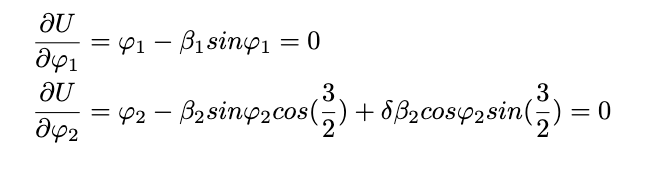

In [ ]:
# mix in y
def Fcn_Mix_in_y(x):
    return [
          x[0] - beta_2 * np.sin(x[0]), 
          x[1] - beta_2 * np.sin(x[1]) * np.cos(3/2) + d_beta_2 * np.cos(x[1]) * np.sin(3/2)
    ]
sol_1 = fsolve(Fcn_Mix_in_y, [2, 0])
sol_2 = fsolve(Fcn_Mix_in_y, [-2, 0])
print(sol_1, sol_2)

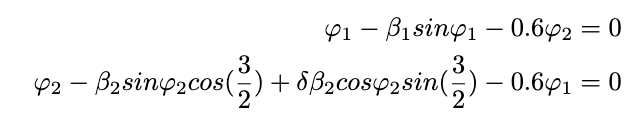

In [ ]:
# Conditional_tilt
def Fcn_conditional_tilt(x):
    return [x[0] - beta_1 * np.sin(x[0]) + -0.6 * x[1],
            x[1] - beta_2 * np.sin(x[1]) * np.cos(3/2) + d_beta_2 * np.cos(x[1]) * np.sin(3/2) + -0.6 * x[0]]

sol_1 = fsolve(Fcn_conditional_tilt, [2.6, 2])
sol_2 = fsolve(Fcn_conditional_tilt, [-2.6, -2])
print(sol_1, sol_2)

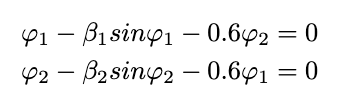

In [ ]:
def Fcn_raise_barrier(x):
    return [x[0] - beta_1 * np.sin(x[0]) - 0.6 * x[1],
            x[1] - beta_2 * np.sin(x[1]) - 0.6 * x[0]
           ]

sol_1 = fsolve(Fcn_raise_barrier, [2.6, 2])
sol_2 = fsolve(Fcn_raise_barrier, [-2.6, -2])
print(sol_1, sol_2)

In [ ]:
def Fcn_conditional_tilt_in_x(x):
    return [
          x[0] - beta_2 * np.sin(x[0]) * np.cos(3/2) + d_beta_2 * np.cos(x[0]) * np.sin(3/2) + -0.6 * x[1],
          x[1] - beta_1 * np.sin(x[1]) + -0.6 * x[0],
    ]
sol_1 = fsolve(Fcn_conditional_tilt_in_x, [2, 2])
sol_2 = fsolve(Fcn_conditional_tilt_in_x, [-2, -2])
print(sol_1, sol_2)

In [ ]:
# mix in y

def Fcn_Mix_in_x(x):
    return [
        x[0] - beta_2 * np.sin(x[0]) * np.cos(3/2) + d_beta_2 * np.cos(x[0]) * np.sin(3/2),
        x[1] - beta_2 * np.sin(x[1])
    ]
sol_1 = fsolve(Fcn_Mix_in_x, [0, 2])
sol_2 = fsolve(Fcn_Mix_in_x, [0, -2])
print(sol_1, sol_2)

In [ ]:
sol

In [ ]:
score_string = """12.5
12.75
15.25
16
16.75
17.25
17.5
18.25
20
20
20
20
20
20
9.25
11.75
12.25
13.25
13.25
14
15.25
15.75
15.75
20
20
20
20
8.5
12.25
13
13.25
14.25
14.5
15
16
17.5
19
19.5
20
20
20
20
20
20
9.25
11
11
12.5
13.25
13.5
15.75
16.75
17.25
17.5
19
20
20
20
20
20"""

In [ ]:
quiz_1_data = [float(s) for s in score_string.split("\n")]

In [ ]:
plt.hist(quiz_1_data)

In [ ]:
sim_id = "36e21ba0a419f66257fdedf5f312f85e4e404beb8a37796c5e9992c32095e690"

In [ ]:
np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}_all_state.npy")

In [ ]:
# comparing two work distributions

In [ ]:
sim_id_1 = "982112af728dc4b2496bee543c0cadeb9a73d86b59c5cc868ed4a941e9874955"
sim_id_2 = "23818bed74c7e71a603fa84bd2fc8b9ffb768f5252fc76562cc57d5de868d76d"

work_distribution_time_array_1 = np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id_1}_work_distribution_time_array.npy")
work_distribution_time_array_2 = np.load(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id_2}_work_distribution_time_array.npy")



In [ ]:

def plot_work_dist_with_time(work_distribution_time_array_1, work_distribution_time_array_2):
    fig, ax = plt.subplots(1, 2)
    
    fig.set_size_inches(10,5)
    
    def animate(i):
        ax[0].clear()
        ax[1].clear()
        # Get the point from the points list at index i
        _dist_1 = work_distribution_time_array_1[i]
        _dist_2 = work_distribution_time_array_2[i]
        work_min = np.min(_dist_1) - 3
        work_max = np.max(_dist_1) + 3
        bins = np.linspace(work_min, work_max, 50)

        # Plot that point using the x and y coordinates
        ax[0].hist(_dist_1, bins = bins)
        ax[1].hist(_dist_2, bins = bins)
        # ax[0].set_title(f"t = {_skipped_step_time_array[i]}")
        # Set the x and y axis to display a fixed range
    ani = animation.FuncAnimation(fig, animate, frames=len(work_distribution_time_array_1),
                        interval=100, repeat=False)
    plt.close()
    return ani




In [ ]:
skip_frame = 25
ani = plot_work_dist_with_time(work_distribution_time_array_1[::skip_frame], work_distribution_time_array_2[::skip_frame])
html = HTML(ani.to_html5_video())



In [ ]:
display(html)

# substage analysis

In [ ]:
t_array = [50, 100, 150, 200, 300, 500]
id_array = ["8aee356774764f477730154fab05226f7bf6571771352d339b28acd53a86cd9f", 
            "6dec0ac15997cf1ec4f572d663b59d7872c7e2439fe28b7358cd9f2da3cc280d",
            "b5ccb03a99261536075d7705af4eb33856182059c242a57b50a0596cb63c617d", 
            "3af89054483684f98067a6fe48d44b7b4b443a0e62e7ed1cac534f8e6a4bc77d", 
            "f7479ff2c7d816ea0bb66a2a1e142a8d0e116161590e99ccca50ddf498c9dcdb", 
            "5c89ebf8e8326a36c84f121f83212af1bbeab847beeb2b15e9c6cdb4216d2d4e"]


In [ ]:
work_done_of_each_step_of_all_t = []
df = loadDataFrame()
for _id in id_array:
    target = getDataByID(df, _id)
    key_work_array = np.array(target.keyStep_work_statistic.values[0])
    print(key_work_array)
    work_done_of_each_step = np.array(key_work_array)[1:] - np.array(key_work_array)[:-1]
    work_done_of_each_step[:, 1] = np.sqrt(np.array(key_work_array)[1:,1]**2 + np.array(key_work_array)[:-1,1]**2) 
    
    
    work_done_of_each_step_of_all_t.append(work_done_of_each_step)
work_done_of_each_step_of_all_t = np.array(work_done_of_each_step_of_all_t)

In [ ]:
N = 1e4

work_done_for_step_1 = work_done_of_each_step_of_all_t[:, 0]
work_done_for_step_2 = work_done_of_each_step_of_all_t[:, 1]
work_done_for_step_3 = work_done_of_each_step_of_all_t[:, 2]
work_done_for_step_4 = work_done_of_each_step_of_all_t[:, 3]
work_done_for_step_5 = work_done_of_each_step_of_all_t[:, 4]
work_done_for_step_6 = work_done_of_each_step_of_all_t[:, 5]
work_done_for_step_7 = work_done_of_each_step_of_all_t[:, 6]
work_done_for_step_8 = work_done_of_each_step_of_all_t[:, 7]

In [ ]:

for x in work_done_of_each_step_of_all_t[0][:, 1]:
    print(f"{3 * x/np.sqrt(N):.3g}")

In [ ]:
N

In [ ]:
work_done_for_step_4

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[18, 6])

ax[0][0].errorbar(x = t_array, y = work_done_for_step_1[:, 0], yerr = 3 * work_done_for_step_1[:, 1]/np.sqrt(N), label = "step 1")
ax[0][1].errorbar(x = t_array, y = work_done_for_step_2[:, 0], yerr = 3 * work_done_for_step_2[:, 1]/np.sqrt(N), label = "step 2")
# ax[0][2].plot(t_array, work_done_for_step_3[:, 0])
ax[0][2].errorbar(x = t_array, y = work_done_for_step_3[:, 0], yerr = 3 * work_done_for_step_3[:, 1]/np.sqrt(N), label = "step 3")
ax[0][3].errorbar(x = t_array, y = work_done_for_step_4[:, 0], yerr = 3 * work_done_for_step_4[:, 1]/np.sqrt(N), label = "step 4")
ax[1][0].errorbar(x = t_array, y = work_done_for_step_5[:, 0], yerr = 3 * work_done_for_step_5[:, 1]/np.sqrt(N), label = "step 5")
ax[1][1].errorbar(x = t_array, y = work_done_for_step_6[:, 0], yerr = 3 * work_done_for_step_6[:, 1]/np.sqrt(N), label = "step 6")
ax[1][2].errorbar(x = t_array, y = work_done_for_step_7[:, 0], yerr = 3 * work_done_for_step_7[:, 1]/np.sqrt(N), label = "step 7")
ax[1][3].errorbar(x = t_array, y = work_done_for_step_8[:, 0], yerr = 3 * work_done_for_step_8[:, 1]/np.sqrt(N), label = "step 8")
[ax[0][i].legend() for i in range(0, 4)]
[ax[1][i].legend() for i in range(0, 4)]
fig.text(0.5, 0.02, 'time', ha='center', fontsize = 15)
fig.text(0.07, 0.5, 'work', va='center', rotation='vertical', fontsize = 15)


In [ ]:
work_done_for_step_1

In [ ]:
work_done_for_step_2

In [ ]:
work_done_for_step_3

In [ ]:
work_done_for_step_4

In [ ]:
work_done_for_step_5

# 1/dt graph plotting

In [ ]:
rc_dict['font.size']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from matplotlib import ticker as mtick



N_array = np.array([1000, 5000, 10000, 50000, 100000, 1000000])
work_array = np.array([0.147, 0.156, 0.143, 0.145, 0.148, 0.146])
work_array_err = np.array([0.0175, 0.0173, 0.0124, 0.00552, 0.00387, 0.00122])
jarzyn_array = np.array([0.924, 0.915, 0.927, 0.937, 0.937, 0.937])
jarzyn_array_err = np.array([0.0146, 0.0147, 0.00993, 0.00473, 0.00335, 0.00106])
work_for_ME_array = np.array([0.859, 0.874, 0.863, 0.86, 0.877, 0.863])
work_for_ME_array_err = np.array([0.0412, 0.0408, 0.028741, 0.012802, 0.0090767, 0.0028642])
work_for_C_array = np.array([-0.711, -0.719, -0.721, -0.715, -0.729, -0.716])
work_for_C_array_err = np.array([0.0448, 0.0443, 0.028724, 0.01279, 0.0091771, 0.0028616])


fig, ax = plt.subplots(2, 2, figsize=[9, 8])

ax[0][0].errorbar(x= N_array, y=work_array,yerr= np.array(work_array_err) * 3, fmt="o", label = "<W>")

ax[0][0].errorbar(x = N_array, y = work_for_ME_array, yerr = work_for_ME_array_err, fmt="x", label=r"$<W_{M}>$")
ax[0][0].errorbar(x = N_array, y = np.array(work_for_C_array), yerr = work_for_C_array_err, fmt="x", label=r"$<W_{C}>$")
ax[0][1].errorbar(x = N_array, y = jarzyn_array, yerr = np.array(jarzyn_array_err) * 3, fmt="o", label="<exp(-W)>", color = "black")

ax[0][0].set_xlabel("N")
ax[0][1].set_xlabel("N")

ax[0][0].set_ylabel(r"work ($k_BT$)")


ax[0][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[0][0].hlines(y=np.log(2), xmin = 900, xmax = 2000000, linestyle = "--")
ax[0][0].hlines(y=-np.log(2), xmin = 900, xmax = 2000000, linestyle = "--")

ax[0][0].legend(fontsize = 10)


# dt_graph

# fig, ax = plt.subplots(1, 2, figsize=[8, 3])
# dt_array = np.array([1/50, 1/100, 1/500, 1/1000, 1/5000])
# work_array = [2.28, 1.18, 0.346, 0.222, 0.143]
# work_array_err = [0.00381, 0.00383, 0.00422, 0.00414, 0.00414]
# jarzyn_array = [0.109, 0.325, 0.758, 0.856, 0.927]
# jarzyn_array_err = [0.000363, 0.00107, 0.00274, 0.00293, 0.00331]
# work_for_ME_array = [1.97, 1.41, 0.977, 0.913, 0.863]
# work_for_ME_array_err = [0.0281, 0.0284, 0.0288, 0.0288, 0.0287]
# work_for_C_array = [0.308, -0.232, -0.631, -0.691, -0.721]
# work_for_C_array_err = [0.0303, 0.0307, 0.0314, 0.0313, 0.0313]


dt_array = np.array([1/50, 1/100, 1/500, 1/1000, 1/5000, 1/10000])
work_array = [2.28, 1.18, 0.346, 0.222, 0.143, 0.128]
work_array_err = [0.00381, 0.00383, 0.00422, 0.00414, 0.00414, 0.0118]
jarzyn_array = [0.109, 0.325, 0.758, 0.856, 0.927, 0.935]
jarzyn_array_err = [0.000363, 0.00107, 0.00274, 0.00293, 0.00331, 0.00927]
work_for_ME_array = [1.97, 1.41, 0.977, 0.913, 0.863, 0.86]
work_for_ME_array_err = [0.0281, 0.0284, 0.0288, 0.0288, 0.0287, 0.0289]
work_for_C_array = [0.308, -0.232, -0.631, -0.691, -0.721, -0.732]
work_for_C_array_err = [0.0303, 0.0307, 0.0314, 0.0313, 0.0313, 0.0312]

# # (c) work analysis
# # measurement + reset = 0.86 ± 0.0289, deviation = 0.167
# # control = -0.732 ± 0.0312, deviation = -0.0393
# # 0.1280853773516335


ax[1][0].errorbar(x=1/dt_array, y=work_array,yerr= np.array(work_array_err) * 3, fmt="o", label = "<W>")
ax[1][0].errorbar(x = 1/dt_array, y = work_for_ME_array, yerr = work_for_ME_array_err, fmt="x", label=r"$<W_{M}>$", color = "orange")
ax[1][0].errorbar(x = 1/dt_array, y = np.array(work_for_C_array), yerr = work_for_C_array_err, fmt="x", label=r"$<W_{C}>$", color = "green")
ax[1][1].errorbar(x = 1/dt_array, y = jarzyn_array, yerr = np.array(jarzyn_array_err) * 3, fmt="o", label="<exp(-W)>", color = "black")


ax[1][0].set_xlabel("1/dt")
ax[1][1].set_xlabel("1/dt")

ax[1][0].set_ylabel(r"work ($k_BT$)")

ax[1][0].set_xscale("log")
ax[1][1].set_xscale("log")
# ax[1][1].hlines(y=np.log(2), xmin = 0, xmax = 10000, linestyle = "--")

# handles, labels = plt.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
ax[1][0].hlines(y=np.log(2), xmin = 20, xmax = 20000, linestyle = "--")
ax[1][0].hlines(y=-np.log(2), xmin = 20, xmax = 20000, linestyle = "--")


ax[0][0].legend(bbox_to_anchor=(1, 0.5), fontsize = 14)
ax[0][1].legend(bbox_to_anchor=(1, 1), fontsize = 14)
# plt.show()


In [ ]:
# N graph plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
t_3_4 = [50, 100, 150, 200, 300, 500]

W_mean = [0.143, 0.153, 0.177, 0.205, 0.214, 0.267]
W_mean_sem = [0.0041, 0.00446, 0.0048, 0.00484, 0.00474, 0.00472]

W_measurement = [0.863, 0.851, 0.842, 0.862, 0.85, 0.847]
W_measurement_sem = [0.0287, 0.028, 0.0289, 0.029, 0.0282, 0.0281]

W_control = [-0.721, -0.702, -0.666, -0.656, -0.636, -0.58]
W_control_sem = [0.0313, 0.0308, 0.0323, 0.032, 0.0315, 0.0314]

In [ ]:
from matplotlib import ticker as mtick
with mpl.rc_context(rc_dict):
    fig, ax = plt.subplots(1, 2, figsize=[10, 4])
    ax[0].errorbar(x=t_3_4, y=W_mean, yerr=W_mean_sem, fmt="o", label=r"$\langle W \rangle$")
    ax[0].legend(bbox_to_anchor=(1, 0.18), fontsize = 13)
    ax[0].set_ylabel(r"Work ($k_BT$)")
    ax[0].set_xlabel(r"t ($\tau_c$) ")
    ax[1].errorbar(x=t_3_4, y=np.array(W_measurement) - 0.693, yerr=W_measurement_sem, fmt="o", label=r"$\langle W_{M} \rangle - k_BT\ln2$")
    ax[1].axhline(y=0, linestyle="--")
    ax[1].errorbar(x=t_3_4, y=np.array(W_control) + 0.693, yerr=W_control_sem, fmt="o", label=r"$\langle W_{C} \rangle + k_BT\ln2$")
    ax[1].set_xlabel(r"t ($\tau_c$) ")
    ax[1].legend(bbox_to_anchor=(1, 0.27), fontsize = 13)

In [ ]:
### dt_analysis for [0, 200, 200, 200, 200, 200, 200, 200, 200]
dt = [1000, 5000, 10000]

W_mean = [0.225, 0.202, 0.193 ]
W_mean_sem = [0.00465, 0.00468, 0.00462]

W_measurement = [0.836, 0.821, 0.815]
W_measurement_sem = [0.027,0.028, 0.0275]

W_control = [-0.611, -0.619, -0.621]
W_control_sem = [0.0821,0.0739, 0.0719


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[8, 3])
ax[0].errorbar(x=dt, y=W_mean, yerr=W_mean_sem, fmt="o", label="total")
ax[0].legend()
ax[1].errorbar(x=dt, y=W_measurement, yerr=W_measurement_sem, fmt="o", label="M")
ax[1].axhline(y=0.693, linestyle="--")
ax[1].errorbar(x=dt, y=-np.array(W_control), yerr=W_control_sem, fmt="o", label="C")
ax[1].legend()

# line graph

### parameter functions

In [ ]:
import glob
sim_id = "73b22918ca8d4ea2a5680d2ca7ff7879"
plotline_graph_array = glob.glob(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{sim_id}*.npy")
print(len(plotline_graph_array))

In [ ]:
dataOrder = [2, 1, 3, 0]
orderedplotline_graph_array = [plotline_graph_array[_i] for _i in dataOrder]


In [ ]:
all_data_array = [np.load(x, allow_pickle=True)[()] for x in orderedplotline_graph_array]
# all_data_array = sorted(all_data_array, key = lambda x:x["dcx"])

In [ ]:
fig_tilte = ["(a) all zero", r"(b) $\varphi_{2xdc} = 3.0$", r"(c) $\varphi_{2x} = -1.5$", r"(d) $m_{12} = -0.6$"]
fig, ax = plt.subplots(2, 4, figsize = [9, 5.5], constrained_layout=True)




for _i, test_data in enumerate(all_data_array):
    contour_plot_X, contour_plot_Y, contour_plot_U, contour_plot_contours = test_data["contour_plot"]["X"], test_data["contour_plot"]["Y"],  test_data["contour_plot"]["U"], test_data["contour_plot"]["contours"]
    cutline_X, cutline_U, cutlineDirection = test_data["cutline_plot"]["plotAxis"], test_data["cutline_plot"]["targetU"], test_data["cutline_plot"]["cutlineDirection"]
    cutlineValue = test_data["cutline_plot"]["cutlineValue"]
    cutline_U = cutline_U - min(cutline_U)
    ax[0][_i].contourf(contour_plot_X, contour_plot_Y, contour_plot_U, 40, vmin = 0, vmax = 400, cmap = "afmhot")
    ax[0][_i].vlines(x = cutlineValue, ymin = np.min(cutline_X), ymax = np.max(cutline_X), colors= "red")
    ax[0][_i].set_title(fig_tilte[_i], fontsize = 14)
    ax[0][_i].set_xlabel(r'$\varphi_1$', fontsize = 16)
    ax[0][_i].set_ylabel(r'$\varphi_2$', fontsize = 16)
    ax[0][_i].set_yticks([])
    ax[0][_i].set_xticks([-4, 0, 4])
    ax[0][_i].xaxis.set_tick_params(labelsize=14)
    ax[0][_i].yaxis.set_tick_params(labelsize=14)


    ax[1][_i].plot(cutline_X, cutline_U, color = "red")
    ax[1][_i].set_ylim(min(cutline_U), 500)
    ax[1][_i].set_ylabel(r'U $(k_BT)$', fontsize = 16)
    ax[1][_i].set_xlabel(r'$\varphi_2$', fontsize = 16)
    ax[1][_i].set_xticks([-4, 0, 4])
    ax[1][_i].set_yticks([])
    ax[1][_i].xaxis.set_tick_params(labelsize=14)
    ax[1][_i].yaxis.set_tick_params(labelsize=14)



contour_plot_X, contour_plot_Y, contour_plot_U, contour_plot_contours = test_data["contour_plot"]["X"], test_data["contour_plot"]["Y"],  test_data["contour_plot"]["U"], test_data["contour_plot"]["contours"]
cutline_X, cutline_U, cutlineDirection = test_data["cutline_plot"]["plotAxis"], test_data["cutline_plot"]["targetU"], test_data["cutline_plot"]["cutlineDirection"]
cutlineValue = test_data["cutline_plot"]["cutlineValue"]
cutline_U = cutline_U - min(cutline_U)
ax[0][_i].vlines(x = -cutlineValue, ymin = np.min(cutline_X), ymax = np.max(cutline_X), colors= "orange")
ax[0][0].set_yticks([-4, 0, 4])
ax[1][0].set_yticks([0, 250, 500])
# ax[0][_i].set_title("(a) all zero", fontsize = 14)
# ax[0][_i].set_xlabel(r'$\varphi_1$', fontsize = 14)
# ax[0][_i].set_ylabel(r'$\varphi_2$', fontsize = 14)


ax[1][_i].plot(-cutline_X, cutline_U, color = "orange")
ax[1][_i].set_ylim(min(cutline_U), 500)
ax[1][_i].set_ylabel(r'U $(k_BT)$', fontsize = 14)
ax[1][_i].set_xlabel(r'$\varphi_2$', fontsize = 14)

[ax[0][_i].set_ylabel('') for _i in [1, 2, 3]]
[ax[1][_i].set_ylabel('') for _i in [1, 2, 3]]


In [ ]:
plt.contourf(contour_plot_X, contour_plot_Y, contour_plot_U, 40, vmin = 0, vmax = 400, cmap = "afmhot", levels=np.linspace(0,500, 10))
colorbar = plt.colorbar(fraction=0.05, pad=0.04,)
colorbar.ax.tick_params(labelsize=24) 

colorbar.set_ticks([0, 100, 200, 300, 400, 500])


In [ ]:


# ], fontsize = 14)
# ax[0][1].set_title(, fontsize = 1
# ax[0][2].set_title(, fontsize = 14)
# ax[0][3].set_title(, fontsize = 14)

In [ ]:
test_data = all_data_array[3]
contour_plot_X, contour_plot_Y, contour_plot_U, contour_plot_contours = test_data["contour_plot"]["X"], test_data["contour_plot"]["Y"],  test_data["contour_plot"]["U"], test_data["contour_plot"]["contours"]
cutline_X, cutline_U, cutlineDirection = test_data["cutline_plot"]["plotAxis"], test_data["cutline_plot"]["targetU"], test_data["cutline_plot"]["cutlineDirection"]
cutlineValue = test_data["cutline_plot"]["cutlineValue"]

### substage potential

In [ ]:
import glob
comment = "2024_7_10_potential_at_each_substage"
exp_id = "690e7d6417a44b44ac499a989445a1c6"
# plotline_graph_array = glob.glob(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/*_{comment}_plotline_graph.npy")
plotline_graph_array = glob.glob(f"coupled_flux_qubit_protocol/coupled_flux_qubit_data_gallery/{exp_id}_*_plotline_graph.npy")
orderedPlotline_graph = [(np.load(filePath, allow_pickle=True)[()], float(filePath.split("/")[-1].split("_")[2])) for filePath in plotline_graph_array]
orderedPlotline_graph = np.array(sorted(orderedPlotline_graph, key = lambda x: x[1]))

In [ ]:
# remove unwanted substages

In [ ]:
skipped_substage = [1, 7]
skipped_substage = []
orderedPlotline_graph_removed_substage = np.delete(orderedPlotline_graph[:, 0], skipped_substage)
print(len(orderedPlotline_graph_removed_substage))

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = [10.7, 5.5], constrained_layout=True)
ax_flatten = ax.flatten()
for _i, test_data in enumerate(orderedPlotline_graph_removed_substage):
    contour_plot_X, contour_plot_Y, contour_plot_U, contour_plot_contours = test_data["contour_plot"]["X"], test_data["contour_plot"]["Y"],  test_data["contour_plot"]["U"], test_data["contour_plot"]["contours"]
    cutline_X, cutline_U, cutlineDirection = test_data["cutline_plot"]["plotAxis"], test_data["cutline_plot"]["targetU"], test_data["cutline_plot"]["cutlineDirection"]
    cutlineValue = test_data["cutline_plot"]["cutlineValue"]
    cutline_U = cutline_U - min(cutline_U)

    ax_flatten[_i].plot(cutline_X, cutline_U)
    ax_flatten[_i].set_title(f"t = {orderedPlotline_graph[_i, 1]}")
    ax_flatten[_i].set_xlim(-4, 4)
    ax_flatten[_i].set_ylim(min(cutline_U), 500)
    ax_flatten[_i].set_ylabel(r'U $(k_BT)$', fontsize = 14)
    ax_flatten[_i].set_xlabel(r'$\varphi_2$', fontsize = 14)

for _i in range(4, 8):
    ax_flatten[_i].set_xlabel(r'$\varphi_1$', fontsize = 14)
    
for _i in [1, 2, 3, 5, 6, 7]:
    ax_flatten[_i].set_ylabel("")

In [ ]:
for _path in plotline_graph_array:
    os.system(f"rm {_path}")

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=[4.5, 8])
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)
ax[0].set_xticks([-4, 0, 4])
ax[0].set_yticks([-4, 0, 4])
ax[0].set_xlabel(r"$\varphi_1$")
ax[0].set_ylabel(r"$\varphi_2$")

ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)
ax[1].set_xticks([-4, 0, 4])
ax[1].set_yticks([-4, 0, 4])
ax[1].set_xlabel(r"$\varphi_1$")
ax[1].set_ylabel(r"$\varphi_2$")

# kill ssh screen

In [ ]:
import os
kill_id_list = [8104]
[os.system(f"screen -XS {_id} quit") for _id in kill_id_list]


In [ ]:
import numpy as np

In [ ]:
t_W_fidelity_trade_off_data.astype(float)

In [ ]:
t_array

In [ ]:
t_array